# Import necessary functions, including:
* data preprocessing steps - to extract then example image for profiling
* profiling classes - classes that will use given model and collect statistics about performance in speed, accuracy, memory footprint, FPS and etc.
* YOLOv8 Lite Wrapper, that uses tensorflow lite under the hood. As tensorflow lite interpreter provides modification to how inference results look like there is implemented certain post-processing steps to reproduce same structure as in original keras_cv YOLOV8Detector head output. In addition, there is helper function to display predictions, that are obtained from this model

In [12]:
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()
from random import choice
from data.prepate_data import run_data_preparation_pipeline
from quantization.lite_wrapper import YOLOv8LiteWrapper
from profiling.profilers import COCOMetricsCalculatorLite, InferenceProfiler, ModelsProfiler
import warnings
warnings.filterwarnings("ignore")

num_classes = 2
input_shape = (640, 640, 3)


# Wrapp quantized models

In [2]:
shuffle_lite_model = YOLOv8LiteWrapper("../quantized_models/shuffle.tflite")
ghost_lite_model = YOLOv8LiteWrapper("../quantized_models/ghost.tflite")
csp_lite_model = YOLOv8LiteWrapper("../quantized_models/csp.tflite")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# Select one image to make predictions and caclulate runtime statistics

In [3]:
gathered_data = run_data_preparation_pipeline()
train_ds, val_ds = gathered_data['train_ds'], gathered_data['val_ds']
val_ds = val_ds.map(lambda imgs, labels: (tf.cast(imgs, tf.float16), labels))
cat_mapping_r = gathered_data['cat_mapping_r']
cat_mapping = gathered_data['cat_mapping']

Path to dataset files: /Users/bsintsov/.cache/kagglehub/datasets/trainingdatapro/cars-video-object-tracking/versions/3


In [4]:
all_val_imgs = []
for window in val_ds:
    imgs, _ = window
    for img in imgs:
        all_val_imgs.append(img)

example_data_for_inf = all_val_imgs[-1].reshape(-1, input_shape[0], input_shape[1], input_shape[2])

2025-11-15 13:26:30.518226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Collect runtime statistics

In [5]:
warnings.filterwarnings("ignore")

profilers = [
    COCOMetricsCalculatorLite(val_ds),
    InferenceProfiler(repeats=50, device='CPU:0', warmup_steps=10, batch_timing=True),
]

models = {
    'ShuffleNetV2-YOLOv8': shuffle_lite_model,
    'CSPDarkNet-YOLOv8': csp_lite_model,
    'GhostNetv2-YOLOv8': ghost_lite_model,
}

general_profiles = ModelsProfiler(profilers=profilers)
profile_results = general_profiles.profile(models, tf.cast(example_data_for_inf, tf.float16))

RUNNING  <profiling.profilers.COCOMetricsCalculatorLite object at 0x140151e10> FOR MODEL ShuffleNetV2-YOLOv8


2025-11-15 13:26:36.935696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RUNNING  <profiling.profilers.InferenceProfiler object at 0x1401cb6d0> FOR MODEL ShuffleNetV2-YOLOv8
RUNNING  <profiling.profilers.COCOMetricsCalculatorLite object at 0x140151e10> FOR MODEL CSPDarkNet-YOLOv8


2025-11-15 13:26:47.131755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RUNNING  <profiling.profilers.InferenceProfiler object at 0x1401cb6d0> FOR MODEL CSPDarkNet-YOLOv8
RUNNING  <profiling.profilers.COCOMetricsCalculatorLite object at 0x140151e10> FOR MODEL GhostNetv2-YOLOv8


2025-11-15 13:26:56.438347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RUNNING  <profiling.profilers.InferenceProfiler object at 0x1401cb6d0> FOR MODEL GhostNetv2-YOLOv8


In [6]:
profile_results

,MaP,MaP@[IoU=50],MaP@[IoU=75],MaP@[area=small],MaP@[area=medium],MaP@[area=large],Recall@[max_detections=1],Recall@[max_detections=10],Recall@[max_detections=100],Recall@[area=small],...,std_latency_sec,CPU:0_fps,ram_delta_mb,cpu_percent_before,cpu_percent_after,cpu_user_time_delta_s,cpu_sys_time_delta_s,gpu_current_mem_mb,gpu_peak_mem_mb,model
0,0.853684,0.970220,0.949320,0.790077,0.922212,0.889871,0.094073,0.883748,0.883748,0.820325,...,0.0,17.117886,0.0,0.1,0.1,9.2332,0.5380,None,None,ShuffleNetV2-YOLOv8
1,0.837446,0.989909,0.960142,0.787161,0.888917,0.913252,0.092925,0.875717,0.875717,0.824390,...,0.0,16.002092,0.0,0.1,0.1,10.0216,0.4952,None,None,CSPDarkNet-YOLOv8
2,0.886519,0.980082,0.970141,0.850833,0.923191,0.877019,0.103442,0.910516,0.910516,0.880081,...,0.0,21.209703,0.0,0.1,0.1,5.2832,0.4347,None,None,GhostNetv2-YOLOv8


# Example of ShuffleNetV2 YOLO Lite model inferences 

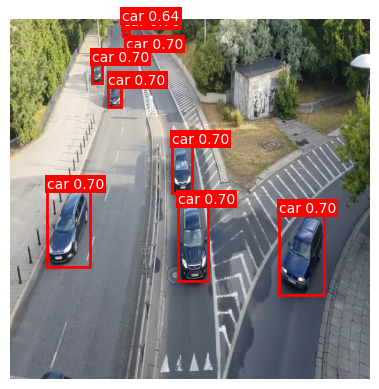

In [7]:
shuffle_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])

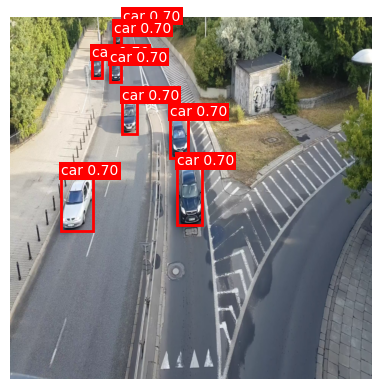

In [14]:
example_data_for_inf = choice(all_val_imgs).reshape(-1, input_shape[0], input_shape[1], input_shape[2])
shuffle_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])


# Example of CSPDarkNet53 YOLO Lite model inferences 

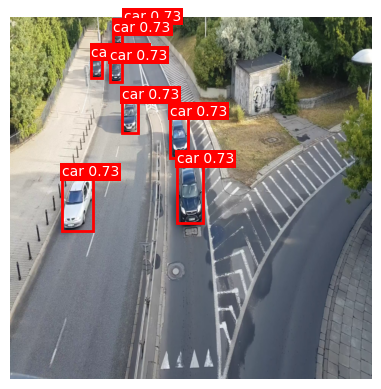

In [15]:
csp_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])

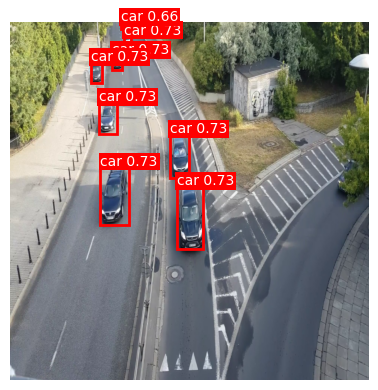

In [22]:
example_data_for_inf = choice(all_val_imgs).reshape(-1, input_shape[0], input_shape[1], input_shape[2])
csp_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])


# Example of GhostNetV2 YOLO Lite model inferences 

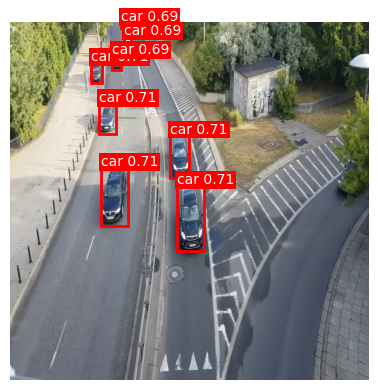

In [23]:
example_data_for_inf = choice(all_val_imgs).reshape(-1, input_shape[0], input_shape[1], input_shape[2])
ghost_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])

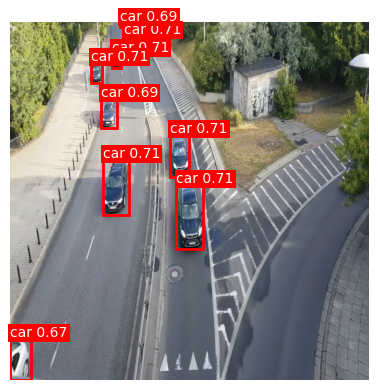

In [24]:
example_data_for_inf = choice(all_val_imgs).reshape(-1, input_shape[0], input_shape[1], input_shape[2])
ghost_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])

In [25]:
profile_results.to_csv("profiling_quantized_results_cpu.csv")